In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score

In [9]:
# Load tab-separated .txt file

df = pd.read_csv("DB_220_IDLH_2mins.txt", sep="\t", index_col=0, header=None)
df['label'] = df.index.str.split("_").str[0] # Extract label from row index (e.g. HCHO_1 -> HCHO)

# Separate features and lables

X = df.drop(columns=['label']).reset_index(drop=True)
X = X.apply(pd.to_numeric)
y = df['label'].apply(lambda x: 'MH' if x.startswith('MH-') else x).reset_index(drop=True)

In [10]:
pd.Series(y).value_counts()

label
HCHO         7
HCl          7
HNO3         7
HF           7
HCN          7
SO2          7
MH           7
NO2          7
F2           7
Cl2          7
Ammonia      7
Arsine       7
TA           7
MA           7
DM           7
H2S          7
Phosgene     7
Phosphine    7
Diborane     7
Control      7
Hydrazine    7
Name: count, dtype: int64

In [11]:
# Define models

# n_neighbors=3
## 기본값은 5인데, 3으로 줄이면 모델이 더 민감하게 반응해서 소수 클래스도 더 잘 구분할 수 있다. 
## 과적합 위험도 있지만, 전자코 데이터셋처럼 클래스별 샘플 수가 작을 때에는 오히려 정확도가 높아질 수 있다.
# n_estimators=100
## 100개의 결정 트리를 만드는 설정
## 너무 적으면 다양성이 부족하고, 너무 많으면 훈련 시간이 오래 걸린다. 100은 성능과 속도 사이의 좋은 균형을 제공하는 기본값이다.
# random_state=1
## 결과가 매번 바뀌지 않도록 재현성을 확보하기 위한 설정
# max_iter=5000
## 최적화 반복 횟수
## 원래 기본값은 100이지만, 고차원 데이터에서 수렴 안되는 경우가 많아 5000으로 설정하였다.
## 특히 전자코 데이터셋처럼 특성 수가 100개가 넘으면, 반복 횟수를 충분히 늘려줘야 학습이 제대로 된다.

models = {
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=1),
    "Logistic Regression": LogisticRegression(max_iter=5000, solver='lbfgs')
}

In [14]:
# Evaluate with 50 seeds
results = {}
for name, model in models.items():
    accuracies = []
    macro_f1s = []
    for seed in range(50):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
        macro_f1s.append(f1_score(y_test, y_pred, average='macro'))
    results[name] = {
        'accuracy': np.mean(accuracies),
        'macro_f1': np.mean(macro_f1s)
    }

In [15]:
results

{'KNN': {'accuracy': 0.9835555555555555, 'macro_f1': 0.988978996510885},
 'Random Forest': {'accuracy': 0.98, 'macro_f1': 0.9809490076732448},
 'Logistic Regression': {'accuracy': 0.9964444444444445,
  'macro_f1': 0.9972026143790851}}

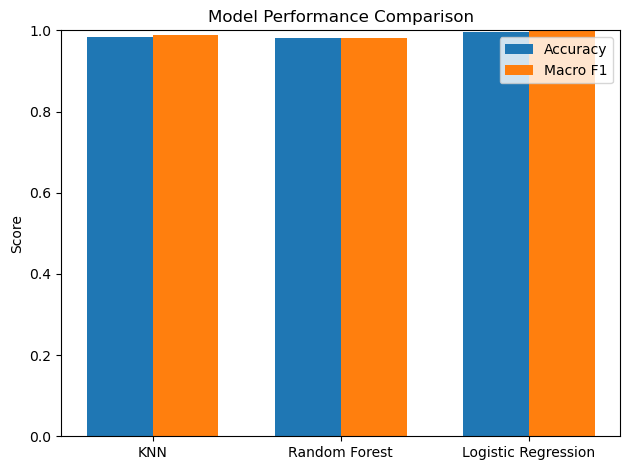

In [16]:
# Plot
labels = list(results.keys())
accs = [results[m]['accuracy'] for m in labels]
f1s = [results[m]['macro_f1'] for m in labels]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, accs, width, label='Accuracy')
rects2 = ax.bar(x + width/2, f1s, width, label='Macro F1')

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("model_performance.png", dpi=300)
plt.show()